In [64]:
from src.helper import load_pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
X_train = load_pickle("data/processed/X_train.pkl")
y_train = load_pickle("data/processed/y_train.pkl")

Step:

1. Bikin binning
2. Cari good and bad distribution in each binning
3. Hitung WOE
4. Plot WOE
5. Hitung IV nya

Summary 16 April 2023 jam 23 di step ini:
1. Overall udah berhasil ngelakuin binning, WOE, dan IV
2. Tapi besok pengen coba explore bagian WOE nya
3. Coba OHE categorical data sebelum WOE dan IV, karena gk ada missing values maka kita coba langsung OHE kan
4. Coba extract nama features dan IV, terus coba di sort buat ngeliat predictive power mana yang paling gede
5. Save as pkl file

In [66]:
dataset = pd.concat([X_train, y_train], axis = 1)

In [67]:
dataset.drop(["SK_ID_CURR"], axis = 1, inplace=True)

#### Binning Process

- Jika menggunakan jumlah bins/group terlalu sedikit, nanti kurang merepresentasikan data yang dimiliki
- Jika memiliki banyak jumlah bins/group nanti terlalu sedikit memberikan informasi

[Source: find the "best" num of binning](https://stats.stackexchange.com/a/810)

In [68]:
dataset.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET
185640,Cash loans,F,N,135000.0,599778.0,28984.5,477000.0,0
266989,Cash loans,F,N,112500.0,152820.0,18135.0,135000.0,0
37682,Cash loans,M,Y,202500.0,540000.0,21546.0,540000.0,0
280087,Cash loans,F,N,157500.0,1350000.0,37255.5,1350000.0,0
255967,Cash loans,F,Y,180000.0,410476.5,37777.5,373500.0,0


In [69]:
num_cols = ["AMT_INCOME_TOTAL", "AMT_CREDIT",
           "AMT_ANNUITY", "AMT_GOODS_PRICE"]

In [56]:
dataset = dataset[num_cols].copy()

In [70]:
dataset

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET
185640,Cash loans,F,N,135000.0,599778.0,28984.5,477000.0,0
266989,Cash loans,F,N,112500.0,152820.0,18135.0,135000.0,0
37682,Cash loans,M,Y,202500.0,540000.0,21546.0,540000.0,0
280087,Cash loans,F,N,157500.0,1350000.0,37255.5,1350000.0,0
255967,Cash loans,F,Y,180000.0,410476.5,37777.5,373500.0,0
...,...,...,...,...,...,...,...,...
206264,Cash loans,F,N,112500.0,405000.0,22099.5,405000.0,0
123969,Cash loans,F,Y,112500.0,1288350.0,37669.5,1125000.0,0
116922,Cash loans,M,N,157500.0,117000.0,14013.0,117000.0,1
118218,Cash loans,F,N,270000.0,900000.0,47952.0,900000.0,0


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

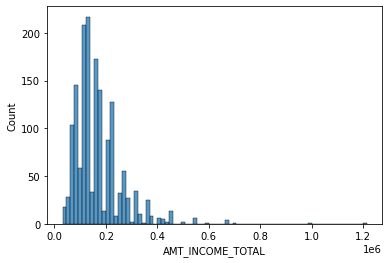

In [71]:
sns.histplot(data = dataset, x = "AMT_INCOME_TOTAL")

In [72]:
def create_binning(data, feature_name):
    data = data.copy()
    data[feature_name + "_bin"] = pd.qcut(data[feature_name], q = 5)
    
    return data

In [73]:
for col in dataset[num_cols]:
    dataset = create_binning(dataset, col)

In [74]:
dataset

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,AMT_INCOME_TOTAL_bin,AMT_CREDIT_bin,AMT_ANNUITY_bin,AMT_GOODS_PRICE_bin
185640,Cash loans,F,N,135000.0,599778.0,28984.5,477000.0,0,"(103500.0, 135000.0]","(438883.2, 620427.6]","(28373.4, 38213.1]","(382500.0, 540000.0]"
266989,Cash loans,F,N,112500.0,152820.0,18135.0,135000.0,0,"(103500.0, 135000.0]","(44999.999, 258159.6]","(14854.5, 21886.2]","(44999.999, 225000.0]"
37682,Cash loans,M,Y,202500.0,540000.0,21546.0,540000.0,0,"(157500.0, 225000.0]","(438883.2, 620427.6]","(14854.5, 21886.2]","(382500.0, 540000.0]"
280087,Cash loans,F,N,157500.0,1350000.0,37255.5,1350000.0,0,"(135000.0, 157500.0]","(900900.0, 2517300.0]","(28373.4, 38213.1]","(860400.0, 2250000.0]"
255967,Cash loans,F,Y,180000.0,410476.5,37777.5,373500.0,0,"(157500.0, 225000.0]","(258159.6, 438883.2]","(28373.4, 38213.1]","(225000.0, 382500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
206264,Cash loans,F,N,112500.0,405000.0,22099.5,405000.0,0,"(103500.0, 135000.0]","(258159.6, 438883.2]","(21886.2, 28373.4]","(382500.0, 540000.0]"
123969,Cash loans,F,Y,112500.0,1288350.0,37669.5,1125000.0,0,"(103500.0, 135000.0]","(900900.0, 2517300.0]","(28373.4, 38213.1]","(860400.0, 2250000.0]"
116922,Cash loans,M,N,157500.0,117000.0,14013.0,117000.0,1,"(135000.0, 157500.0]","(44999.999, 258159.6]","(3302.999, 14854.5]","(44999.999, 225000.0]"
118218,Cash loans,F,N,270000.0,900000.0,47952.0,900000.0,0,"(225000.0, 1215000.0]","(620427.6, 900900.0]","(38213.1, 123480.0]","(860400.0, 2250000.0]"


TIL, crosstab ini itu mirip contingency table

In [95]:
tst = pd.crosstab(dataset["AMT_CREDIT_bin"], dataset["TARGET"])

In [97]:
tst["Good Distribution"] = round(tst[0]/np.sum(tst[0]), 2)

In [98]:
tst

TARGET,0,1,Good Distribution
AMT_CREDIT_bin,,,
"(44999.999, 258159.6]",292,28,0.2
"(258159.6, 438883.2]",288,32,0.2
"(438883.2, 620427.6]",294,26,0.2
"(620427.6, 900900.0]",300,20,0.2
"(900900.0, 2517300.0]",298,22,0.2


### Calculate WOE

Log odds from 

`good_proportion` / `bad_proportion`

In [103]:
def woe(df, feature_name):
    # make probability analysis
    feature_name = df.groupby(feature_name).agg(num_observation=('TARGET','count'),
                                                good_loan_prob=('TARGET','mean')).reset_index()
    
    # find grade proportion
    feature_name['grade_proportion'] = feature_name['num_observation']/feature_name['num_observation'].sum()
    
    # find number of good loan
    feature_name['num_good_loan'] = feature_name['grade_proportion'] * feature_name['num_observation']

    # find number of bad loan
    feature_name['num_bad_loan'] = (1-feature_name['grade_proportion']) * feature_name['num_observation']

    # find good loan proportion
    feature_name['good_loan_prop'] = feature_name['num_good_loan'] / feature_name['num_good_loan'].sum()

    # find bad loan proportion
    feature_name['bad_loan_prop'] = feature_name['num_bad_loan'] / feature_name['num_bad_loan'].sum()

    # find Weight of Evidence
    feature_name['weight_of_evidence'] = np.log(feature_name['good_loan_prop'] / feature_name['bad_loan_prop'])

    # sort values by weight of evidence
    feature_name = feature_name.sort_values('weight_of_evidence').reset_index(drop=True)
    
    # find difference each good loan proportion
    feature_name['good_loan_prop_diff'] = feature_name['good_loan_prop'].diff().abs()

    # find difference each weight of evidence
    feature_name['diff_woe'] = feature_name['weight_of_evidence'].diff().abs()
    
    # find information value
    feature_name['information_value'] = (feature_name['good_loan_prop']-feature_name['bad_loan_prop']) * feature_name['weight_of_evidence']
    feature_name['information_value'] = feature_name['information_value'].sum()
    
    return feature_name

In [107]:
def plot_woe(data, xlabel_rotation=0):
    plt.figure(figsize=(8,4))
    sns.pointplot(x=data.columns[0], y='weight_of_evidence', data=data, marker='o', linestyle='--', color='blue')
    plt.title(str('Weight of Evidence by ' + data.columns[0]))
    plt.xticks(rotation = xlabel_rotation)

### Numerical Data 

In [106]:
woe(dataset, "AMT_INCOME_TOTAL_bin")

,AMT_INCOME_TOTAL_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,"(135000.0, 157500.0]",191,0.089005,0.119375,22.800625,168.199375,0.065792,0.134190,-0.712762,NaN,NaN,0.111988
1,"(225000.0, 1215000.0]",244,0.053279,0.152500,37.210000,206.790000,0.107370,0.164978,-0.429526,0.041579,0.283236,0.111988
2,"(31499.999, 103500.0]",335,0.071642,0.209375,70.140625,264.859375,0.202392,0.211306,-0.043097,0.095022,0.386429,0.111988
3,"(157500.0, 225000.0]",385,0.075325,0.240625,92.640625,292.359375,0.267317,0.233245,0.136344,0.064924,0.179441,0.111988
4,"(103500.0, 135000.0]",445,0.101124,0.278125,123.765625,321.234375,0.357129,0.256282,0.331819,0.089812,0.195475,0.111988


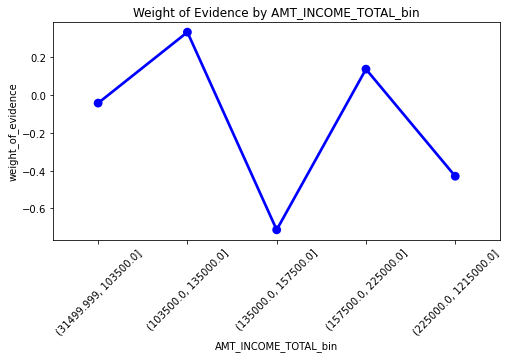

In [112]:
plot_woe(woe(dataset, "AMT_INCOME_TOTAL_bin"), 45)

In [83]:
woe(dataset, "AMT_CREDIT_bin")

,AMT_CREDIT_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,"(44999.999, 258159.6]",320,0.08750,0.2,64.0,256.0,0.2,0.2,0.0,NaN,NaN,0.0
1,"(258159.6, 438883.2]",320,0.10000,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0
2,"(438883.2, 620427.6]",320,0.08125,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0
3,"(620427.6, 900900.0]",320,0.06250,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0
4,"(900900.0, 2517300.0]",320,0.06875,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0


yang ini agak aneh, gk ada value WOE nya

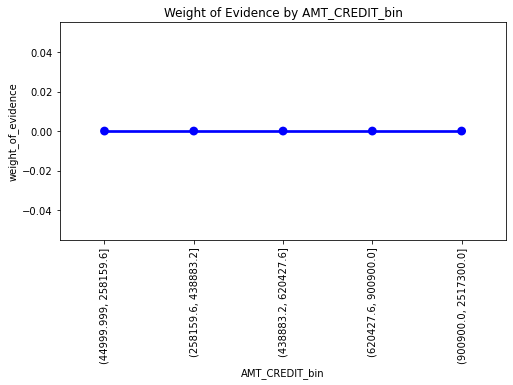

In [114]:
plot_woe(woe(dataset, "AMT_CREDIT_bin"), 90)

In [84]:
woe(dataset, "AMT_ANNUITY_bin")

,AMT_ANNUITY_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,"(3302.999, 14854.5]",320,0.084375,0.2,64.0,256.0,0.2,0.2,0.0,NaN,NaN,0.0
1,"(14854.5, 21886.2]",320,0.084375,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0
2,"(21886.2, 28373.4]",320,0.084375,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0
3,"(28373.4, 38213.1]",320,0.090625,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0
4,"(38213.1, 123480.0]",320,0.056250,0.2,64.0,256.0,0.2,0.2,0.0,0.0,0.0,0.0


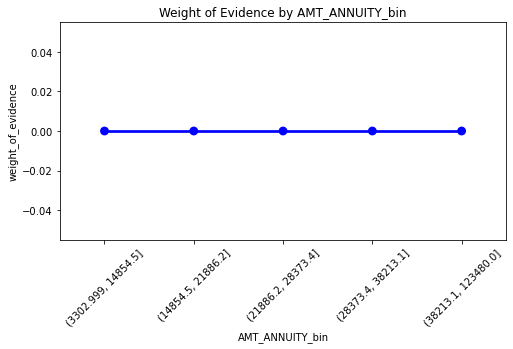

In [117]:
plot_woe(woe(dataset, "AMT_ANNUITY_bin"), 45)

In [85]:
woe(dataset, "AMT_GOODS_PRICE_bin")

,AMT_GOODS_PRICE_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,"(225000.0, 382500.0]",275,0.101818,0.171875,47.265625,227.734375,0.146250,0.178361,-0.198493,NaN,NaN,0.015523
1,"(540000.0, 860400.0]",302,0.072848,0.188750,57.002500,244.997500,0.176378,0.191882,-0.084249,0.030128,0.114244,0.015523
2,"(860400.0, 2250000.0]",320,0.059375,0.200000,64.000000,256.000000,0.198030,0.200499,-0.012390,0.021652,0.071859,0.015523
3,"(382500.0, 540000.0]",332,0.075301,0.207500,68.890000,263.110000,0.213160,0.206067,0.033843,0.015131,0.046233,0.015523
4,"(44999.999, 225000.0]",371,0.091644,0.231875,86.025625,284.974375,0.266182,0.223191,0.176150,0.053021,0.142307,0.015523


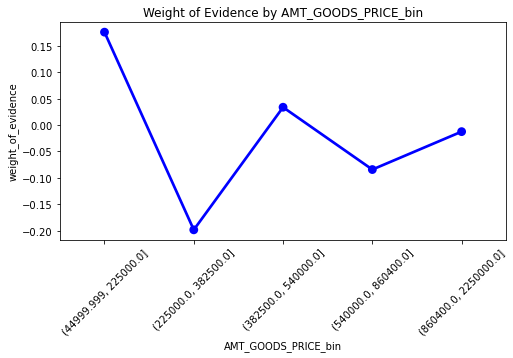

In [119]:
plot_woe(woe(dataset, "AMT_GOODS_PRICE_bin"), 45)

### Categorical Data 

In [120]:
dataset

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,AMT_INCOME_TOTAL_bin,AMT_CREDIT_bin,AMT_ANNUITY_bin,AMT_GOODS_PRICE_bin
185640,Cash loans,F,N,135000.0,599778.0,28984.5,477000.0,0,"(103500.0, 135000.0]","(438883.2, 620427.6]","(28373.4, 38213.1]","(382500.0, 540000.0]"
266989,Cash loans,F,N,112500.0,152820.0,18135.0,135000.0,0,"(103500.0, 135000.0]","(44999.999, 258159.6]","(14854.5, 21886.2]","(44999.999, 225000.0]"
37682,Cash loans,M,Y,202500.0,540000.0,21546.0,540000.0,0,"(157500.0, 225000.0]","(438883.2, 620427.6]","(14854.5, 21886.2]","(382500.0, 540000.0]"
280087,Cash loans,F,N,157500.0,1350000.0,37255.5,1350000.0,0,"(135000.0, 157500.0]","(900900.0, 2517300.0]","(28373.4, 38213.1]","(860400.0, 2250000.0]"
255967,Cash loans,F,Y,180000.0,410476.5,37777.5,373500.0,0,"(157500.0, 225000.0]","(258159.6, 438883.2]","(28373.4, 38213.1]","(225000.0, 382500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
206264,Cash loans,F,N,112500.0,405000.0,22099.5,405000.0,0,"(103500.0, 135000.0]","(258159.6, 438883.2]","(21886.2, 28373.4]","(382500.0, 540000.0]"
123969,Cash loans,F,Y,112500.0,1288350.0,37669.5,1125000.0,0,"(103500.0, 135000.0]","(900900.0, 2517300.0]","(28373.4, 38213.1]","(860400.0, 2250000.0]"
116922,Cash loans,M,N,157500.0,117000.0,14013.0,117000.0,1,"(135000.0, 157500.0]","(44999.999, 258159.6]","(3302.999, 14854.5]","(44999.999, 225000.0]"
118218,Cash loans,F,N,270000.0,900000.0,47952.0,900000.0,0,"(225000.0, 1215000.0]","(620427.6, 900900.0]","(38213.1, 123480.0]","(860400.0, 2250000.0]"


In [121]:
woe(dataset, "NAME_CONTRACT_TYPE")

,NAME_CONTRACT_TYPE,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,Revolving loans,132,0.083333,0.0825,10.89,121.11,0.00802,0.5,-4.132614,NaN,NaN,2.370214
1,Cash loans,1468,0.079700,0.9175,1346.89,121.11,0.99198,0.5,0.685094,0.983959,4.817709,2.370214


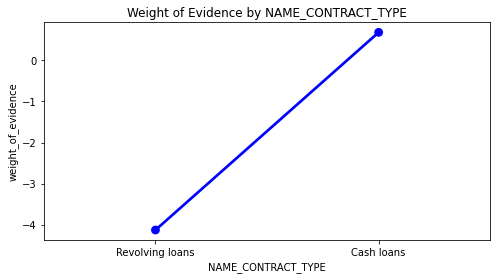

In [122]:
plot_woe(woe(dataset, "NAME_CONTRACT_TYPE"))

In [123]:
woe(dataset, "CODE_GENDER")

,CODE_GENDER,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,M,535,0.102804,0.334375,178.890625,356.109375,0.201503,0.5,-0.908804,NaN,NaN,0.411008
1,F,1065,0.068545,0.665625,708.890625,356.109375,0.798497,0.5,0.468123,0.596994,1.376927,0.411008


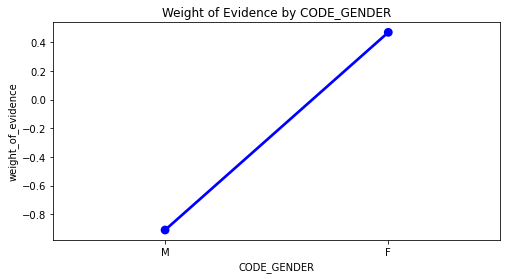

In [124]:
plot_woe(woe(dataset, "CODE_GENDER"))

In [125]:
woe(dataset, "FLAG_OWN_CAR")

,FLAG_OWN_CAR,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,Y,562,0.058719,0.35125,197.4025,364.5975,0.22669,0.5,-0.791026,NaN,NaN,0.335379
1,N,1038,0.091522,0.64875,673.4025,364.5975,0.77331,0.5,0.436072,0.546621,1.227098,0.335379


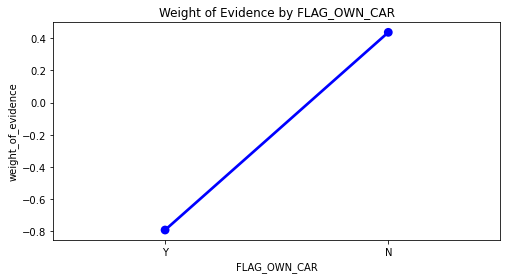

In [126]:
plot_woe(woe(dataset, "FLAG_OWN_CAR"))

#### Extract IV and Features Name 

TODO: bikin function yang buat extract IV dan nama features nya terus di sorting

In [ ]:
def extract_IV(data):
    result = []
    result = pd.DataFrame()
    
    for col in data.columns:
        tmp = woe(data, col)
        result.append(tmp)

In [130]:
for col in dataset.columns:
    print(woe(dataset,col))

  NAME_CONTRACT_TYPE  num_observation  ...  diff_woe  information_value
0    Revolving loans              132  ...       NaN           2.370214
1         Cash loans             1468  ...  4.817709           2.370214

[2 rows x 12 columns]
  CODE_GENDER  num_observation  ...  diff_woe  information_value
0           M              535  ...       NaN           0.411008
1           F             1065  ...  1.376927           0.411008

[2 rows x 12 columns]
  FLAG_OWN_CAR  num_observation  ...  diff_woe  information_value
0            Y              562  ...       NaN           0.335379
1            N             1038  ...  1.227098           0.335379

[2 rows x 12 columns]
     AMT_INCOME_TOTAL  num_observation  ...  diff_woe  information_value
0             31500.0                1  ...       NaN           0.965209
1            239998.5                1  ...  0.000000           0.965209
2            237600.0                1  ...  0.000000           0.965209
3            233100.0         

In [131]:
dataset

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,AMT_INCOME_TOTAL_bin,AMT_CREDIT_bin,AMT_ANNUITY_bin,AMT_GOODS_PRICE_bin
185640,Cash loans,F,N,135000.0,599778.0,28984.5,477000.0,0,"(103500.0, 135000.0]","(438883.2, 620427.6]","(28373.4, 38213.1]","(382500.0, 540000.0]"
266989,Cash loans,F,N,112500.0,152820.0,18135.0,135000.0,0,"(103500.0, 135000.0]","(44999.999, 258159.6]","(14854.5, 21886.2]","(44999.999, 225000.0]"
37682,Cash loans,M,Y,202500.0,540000.0,21546.0,540000.0,0,"(157500.0, 225000.0]","(438883.2, 620427.6]","(14854.5, 21886.2]","(382500.0, 540000.0]"
280087,Cash loans,F,N,157500.0,1350000.0,37255.5,1350000.0,0,"(135000.0, 157500.0]","(900900.0, 2517300.0]","(28373.4, 38213.1]","(860400.0, 2250000.0]"
255967,Cash loans,F,Y,180000.0,410476.5,37777.5,373500.0,0,"(157500.0, 225000.0]","(258159.6, 438883.2]","(28373.4, 38213.1]","(225000.0, 382500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
206264,Cash loans,F,N,112500.0,405000.0,22099.5,405000.0,0,"(103500.0, 135000.0]","(258159.6, 438883.2]","(21886.2, 28373.4]","(382500.0, 540000.0]"
123969,Cash loans,F,Y,112500.0,1288350.0,37669.5,1125000.0,0,"(103500.0, 135000.0]","(900900.0, 2517300.0]","(28373.4, 38213.1]","(860400.0, 2250000.0]"
116922,Cash loans,M,N,157500.0,117000.0,14013.0,117000.0,1,"(135000.0, 157500.0]","(44999.999, 258159.6]","(3302.999, 14854.5]","(44999.999, 225000.0]"
118218,Cash loans,F,N,270000.0,900000.0,47952.0,900000.0,0,"(225000.0, 1215000.0]","(620427.6, 900900.0]","(38213.1, 123480.0]","(860400.0, 2250000.0]"
